## Learning with Massive Data
### Assignment 2 - Studying Sparse-Dense Retrieval
#### Giovanni Costa - 880892

Contents:
- [Sparse representation](#s_repr)
- [Dense representation](#d_repr)
- [Top k retrieval](#exact_retr)
- [Top k\' retrieval (approximate case)](#approx_retr)
- [Evaluations](#eval)

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import words
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

data_dir="datasets/"
dataset_name_dir="trec-covid/"

In [2]:
corpus=pd.read_json(data_dir+dataset_name_dir+"corpus.jsonl", lines=True)
queries=pd.read_json(data_dir+dataset_name_dir+"queries.jsonl", lines=True)

In [ ]:
corpus.info()

In [ ]:
corpus.head(2)

In [ ]:
queries.info()

In [ ]:
queries.head(2)

<a id='s_repr'></a>
### Sparse representation

In [ ]:
#Sk-learn's "TfidfVectorizer" and "CountVectorizer" extension to provide the stemming feature
class StemmedTfidfVectorizer(TfidfVectorizer):
    stemmer = PorterStemmer()
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (StemmedTfidfVectorizer.stemmer.stem(w) for w in analyzer(doc))
    
class StemmedTfidfCountVectorizer(CountVectorizer):
    stemmer = PorterStemmer()
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: (StemmedTfidfCountVectorizer.stemmer.stem(w) for w in analyzer(doc))
    
    
def compute_sparse_repr(vocab: np.array, corpus: pd.DataFrame, queries: pd.DataFrame):
    #Extract only the word and the numbers, made a lowercase transformation and usage of custom vocabulary to make representations independent
    doc_tfidf=StemmedTfidfVectorizer(lowercase=True, vocabulary=vocab, stop_words=None, token_pattern=r'\w+')
    q_counter=StemmedTfidfCountVectorizer(lowercase=True, vocabulary=vocab, stop_words=None, token_pattern=r'\w+')

    #Computation of the sparse embedding
    sparse_doc=doc_tfidf.fit_transform(corpus["text"])
    sparse_q=q_counter.fit_transform(queries["text"])

    return sparse_doc, sparse_q

In [ ]:
#Stem the vocabulary and drop the duplicates
stemmer=PorterStemmer()
vocab=np.unique([stemmer.stem(w) for w in np.char.lower(words.words())])

sparse_doc, sparse_q=compute_sparse_repr(vocab, corpus, queries)

#Here it's basically computed sparse_score=<q_sparse, d_sparse>
sparse_score_df=pd.DataFrame(np.dot(sparse_q, sparse_doc.transpose()).toarray(), index=queries["_id"], columns=corpus["_id"])

In [ ]:
sparse_score_df.to_parquet("sparse_score_df_covid.parquet")

<a id='d_repr'></a>
### Dense representation

In [ ]:
def compute_dense_repr(corpus: pd.DataFrame, queries: pd.DataFrame):
    transformers = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    ##Computation of the dense embedding
    dense_c=transformers.encode(corpus["text"], convert_to_numpy = True)
    dense_q=transformers.encode(queries["text"], convert_to_numpy = True)
    
    return dense_c, dense_q

In [ ]:
dense_c, dense_q=compute_dense_repr(corpus, queries)

#Here it's basically computed dense_score=<q_dense, d_dense>
dense_score_df=pd.DataFrame(np.dot(dense_q, dense_c.transpose()), index=queries["_id"], columns=corpus["_id"])

In [ ]:
dense_score_df.to_parquet("dense_score_df_covid.parquet")

<a id='exact_retr'></a>
## Top k retrieval

In [3]:
sparse_score_df=pd.read_parquet("sparse_score_df_covid.parquet")
dense_score_df=pd.read_parquet("dense_score_df_covid.parquet")

In [4]:
sparse_score_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 1 to 50
Columns: 171332 entries, ug7v899j to pnl9th2c
dtypes: float32(171332)
memory usage: 32.7 MB


In [5]:
dense_score_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 1 to 50
Columns: 171332 entries, ug7v899j to pnl9th2c
dtypes: float32(171332)
memory usage: 32.7 MB


In [6]:
def compute_exact_retrieval(sparse_score_df: pd.DataFrame, dense_score_df: pd.DataFrame, k: int):
    #Sum the two scores
    total_score_df=sparse_score_df+dense_score_df

    #Get the exact top-k documents indexes
    idx_exact_top_k=np.argsort(total_score_df)[:, :-k-1:-1]
    #Get the exact top-k documents ids
    top_k_exact_docs=np.array(total_score_df.columns[idx_exact_top_k.reshape(-1)]).reshape(-1, k)

    return total_score_df, top_k_exact_docs

In [7]:
k=5
total_score_df, top_k_exact_docs=compute_exact_retrieval(sparse_score_df, dense_score_df, k)

In [8]:
total_score_df.head(2)

_id,ug7v899j,02tnwd4m,ejv2xln0,2b73a28n,9785vg6d,zjufx4fo,5yhe786e,8zchiykl,8qnrcgnk,jg13scgo,...,fvhq8yud,plp5sxyl,cpgcp7cs,yz0buegp,08gqn86z,7e8r61e7,6jittbis,hi8k8wvb,ma3ndg41,pnl9th2c
_id,,,,,,,,,,,,,,,,,,,,,
1,0.453372,0.584910,0.582493,0.345679,0.544013,0.600357,0.190219,0.496787,0.248941,0.388101,...,-0.016971,0.812093,0.686764,0.599872,0.551895,-0.016971,0.204954,0.398401,1.134267,-0.016971
2,0.514232,0.637419,0.680840,0.360693,0.862798,0.771147,0.510018,0.422742,0.492347,0.695964,...,0.016533,0.886815,0.978100,0.691514,0.811774,0.016533,0.450004,0.711241,1.040751,0.016533


In [9]:
top_k_exact_docs[0]

array(['dv9m19yk', 'vpodtbjk', '76gbhh40', '75773gwg', 'sjyrr2bn'],
      dtype=object)

<a id='approx_retr'></a>
## Top k' retrieval (approximate case)

In [10]:
def compute_approx_retrieval(sparse_score_df: pd.DataFrame, dense_score_df: pd.DataFrame, total_score_df: pd.DataFrame, k_prime: int):
    #Get the indexes of top-k' docs for the sparse representations
    idx_sparse_scores=np.argsort(sparse_score_df)[:, :-k_prime-1:-1]
    #Get the indexes of top-k' docs for the dense representations
    idx_dense_scores=np.argsort(dense_score_df)[:, :-k_prime-1:-1]

    #Merging of the two vectors of indexes
    concat_idx=np.concatenate((idx_sparse_scores, idx_dense_scores), axis=1)
    #Drop duplicates in every row
    union_idx=[np.unique(x) for x in concat_idx]

    #Get the indexes of the top-k documents given the merged approximate sets:
    #for every query, take the top-k indexes using the specific indexes of the merged set, based on total_score computed previous
    idx_approx_top_k=np.asarray([ union_idx[i][np.argsort(total_score_df.iloc[i, union_idx[i]])[:-k-1:-1].values]
                                  for i in range(len(union_idx)) ])
    
    #Get the doc ids from the retrieved indexes
    top_k_approx_docs=np.array(total_score_df.columns[idx_approx_top_k.reshape(-1)]).reshape(-1, k)

    return top_k_approx_docs

In [11]:
top_k_approx_docs=compute_approx_retrieval(sparse_score_df, dense_score_df, total_score_df, k)

In [12]:
top_k_approx_docs[0]

array(['dv9m19yk', '7nhnds83', 'mm4ngrla', '1loqavom', 'euv03cul'],
      dtype=object)

<a id='eval'></a>
## Evaluations

In [13]:
k_list=[5, 10, 15]

mean_recalls_list=[[], [], []]
top_k_exact_approx_lists=[[], [], []]
max_k_prime_list=[]
epsilon=0.01
step=1
i=0
for k in k_list:
    total_score_df, top_k_exact_docs=compute_exact_retrieval(sparse_score_df, dense_score_df, k)
    for k_prime in range(k, len(corpus)+1, step):
        top_k_approx_docs=compute_approx_retrieval(sparse_score_df, dense_score_df, total_score_df, k_prime)
        recalls=[len(np.intersect1d(top_k_exact_docs[i], top_k_approx_docs[i], assume_unique=True))/k for i in range(len(top_k_exact_docs))]
        mean=np.mean(recalls)
        mean_recalls_list[i].append(mean)

        if mean>=1-epsilon or k==len(corpus):
            print(k_prime)
            max_k_prime_list.append(k_prime)
            break
    i+=1


32
61
73


In [14]:
for i in range(len(k_list)):
    print("K: ", k_list[i])
    idx=np.argmax(mean_recalls_list[i])
    print("Exit threshold: ", 1-epsilon)
    print("Highest recall w.r.t. exact solution: ", mean_recalls_list[i][idx], ",")
    print("obtained with k\': ", max_k_prime_list[i])
    print()


K:  5
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.992 ,
obtained with k':  32

K:  10
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.99 ,
obtained with k':  61

K:  15
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.9906666666666666 ,
obtained with k':  73



K:  5


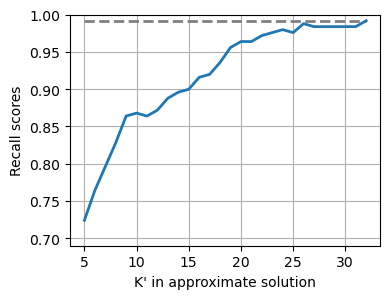

K:  10


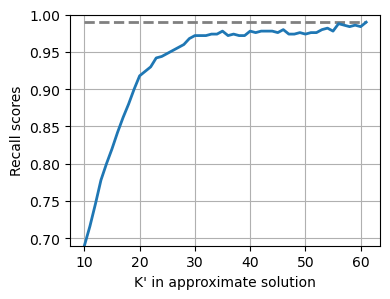

K:  15


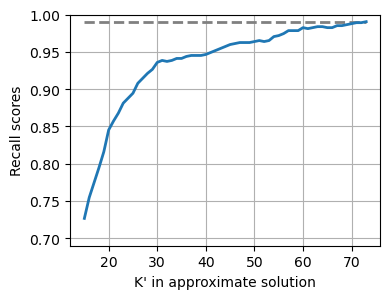

In [16]:
for i in range(len(k_list)):
    print("K: ", k_list[i])
    plt.figure(figsize=(4, 3))
    plt.ylabel('Recall scores')
    plt.xlabel('K\' in approximate solution')

    plt.ylim(np.min(np.concatenate(mean_recalls_list)), 1)
    #plt.xlim(k_list[i], max_k_prime_list[i])

    plt.grid()
    plt.hlines(np.max(mean_recalls_list[i]), k_list[i], max_k_prime_list[i], linewidth=2, linestyles="dashed", colors="grey")
    plt.plot(range(k_list[i], max_k_prime_list[i]+1, step), mean_recalls_list[i], linewidth=2)
    plt.show()